# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(len(trainloader) * 64)

50048


Image shape:  torch.Size([3, 32, 32])
      ship      truck        cat       frog


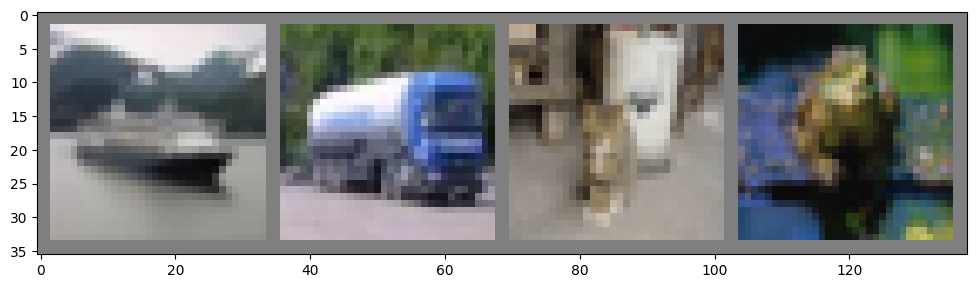

In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs. 
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 1st conv layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 2nd conv layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 3rd conv layer

        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512) # Adjust size according to the output of the last conv layer
        self.fc2 = nn.Linear(512, 10) # 10 classes for CIFAR-10

        # Dropout
        self.dropout = nn.Dropout(0.5)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
        # Applying convolutions, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv1(x))) # 1st conv block
        x = self.pool(F.relu(self.conv2(x))) # 2nd conv block
        x = self.pool(F.relu(self.conv3(x))) # 3rd conv block

        x = x.view(-1, 128 * 4 * 4) # Flatten for FC layers

        x = self.dropout(F.relu(self.fc1(x))) # 1st FC layer with dropout
        x = self.fc2(x) # 2nd FC layer (output layer)
        
        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net()
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   # 
#############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

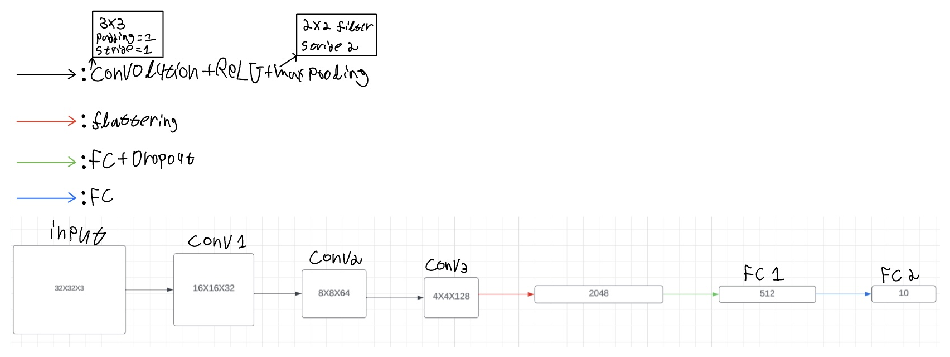

In [9]:
import matplotlib.image as mpimg

image_path = 'diagram.jpg'
img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')  
plt.show()

In [10]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)


for epoch in range(num_epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # Unpack the data into images and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Run the forward pass and compute the loss
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'epoch {epoch + 1} loss: {running_loss / len(trainset):.3f}') # Print statistics
    

print('Finished Training')

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

epoch 1 loss: 0.027
epoch 2 loss: 0.020
epoch 3 loss: 0.016
epoch 4 loss: 0.013
epoch 5 loss: 0.012
Finished Training


## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)** 

In [11]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
# Set the model to evaluation mode
net.eval()

correct = 0
total = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for data in testloader:
        # Unpack the data into images and labels
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = net(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum().item()

        # Update the confusion matrix
        for label, prediction in zip(labels, predicted):
            confusion_matrix[label][prediction] += 1

# Calculate the accuracy
model_accuracy = 100 * correct / total

print('Confusion Matrix:\n', confusion_matrix)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Confusion Matrix:
 [[833  22  23  23   9   0   3   7  37  43]
 [ 17 867   2   7   2   0   2   5  13  85]
 [ 95   6 607  97  68  36  39  28  12  12]
 [ 38  17  56 671  43  71  26  39  13  26]
 [ 38   6  72 101 663  16  26  71   5   2]
 [ 23   6  42 299  29 512   8  58   9  14]
 [ 11  15  55 115  44  12 720   6   9  13]
 [ 21   5  36  60  40  27   3 792   3  13]
 [ 75  42   6  17   4   2   1   2 819  32]
 [ 41  76   5  14   4   2   0  10  16 832]]
Model accuracy on 10000 test images: 73.16%


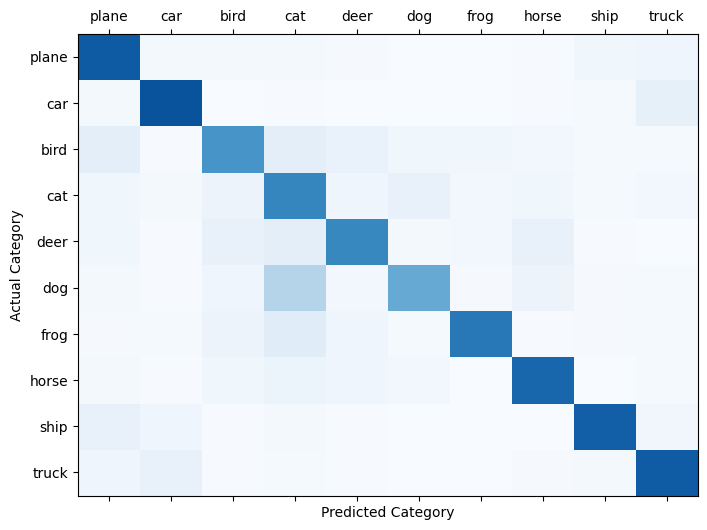

In [12]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:** 
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:** In developing the CNN, I experimented iteratively: different filter sizes (3x3, 5x5) were tested, with smaller 3x3 filters proving more efficient for detail capture. The number of filters per layer was varied (e.g., 32, 64, 128) and Various dropout rates (0.3 to 0.7) were trialed, with 0.5 striking an optimal balance between regularization and learning. The network depth was adjusted, and three convolutional layers coupled with two fully connected layers emerged as a well-balanced structure.
Larger 5x5 filters increased computational complexity without significant feature detection benefits, Dropout rates above 0.5 caused excessive information loss, while rates below 0.3 inadequately prevented overfitting, more layers lead to overfitting and much more time complexity and fewer failed to capture image complexity.

##**Question:** 
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:** 
The confusion matrix shows which classes are correctly identified and which are confused with others, revealing the model's strengths and weaknesses in class-specific accuracy. We can see that my matrix has a dominated diagonal which means mostly correct classification. It's crucial alongside accuracy because it uncovers biases, misclassifications, and potential issues with class imbalance. Precision and recall are also needed to evaluate performance comprehensively, especially in datasets where some classes are underrepresented or the cost of false positives/negatives is significant.
For example if we had a disease with 1% illness rate in the population and we want a test to discover it, if we would simply tell each sample is healthy we would get around 99% accuracy but that doesn't tell us the test is a good one. 

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [13]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [14]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

In [15]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [16]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)
print(len(list(dataloaders['train'])))

{'train': 636, 'val': 158}
20


In [17]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 1200x800 with 0 Axes>

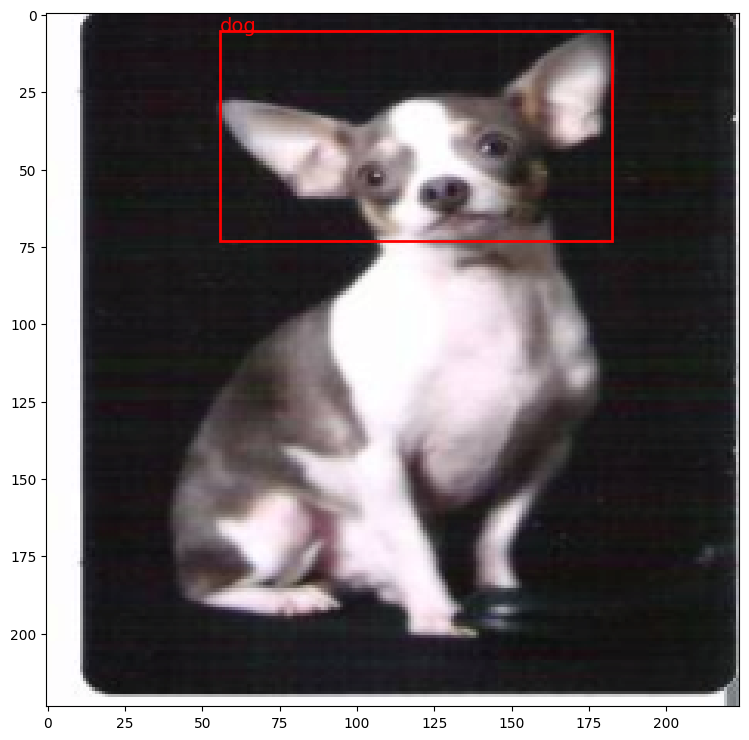

In [18]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [19]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only       #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # Clarrification - You required to build 2 models - one for classification  #
        # and one for detection.                                                    #
        # The classification model is of shape: resent_features -> FC/FCs -> scores.#
        # The detection model is of shape: resent_features -> FC/FCs -> bbox.       #
        # You may train/leave frozen the resent_features backbone, try              #
        # experimenting with it.                                                    #
        # This function has no return value.                                        #
        #############################################################################
        self.net = resnet18
        
        last_layer_input_size = self.net.fc.in_features
        
        self.net = nn.Sequential(*list(self.net.children())[:-1]) # Remove the last fully connected layer   

        for param in self.net.parameters(): # Freeze the weights of the backbone
            param.requires_grad = False
        
        # Add the new fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(last_layer_input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )
        
        # Add the new fully connected layers for localization
        self.localization = nn.Sequential(
            nn.Linear(last_layer_input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 4)
        )
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        
        x = self.net(images) # Forward the image through the feature extractor
        x = x.view(x.size(0), -1) # Flatten the output for the fully connected layers
        class_scores = self.classifier(x) # Forward the features through the classification layers
        bbox = self.localization(x) # Forward the features through the localization layers
        
        return class_scores, bbox
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################


## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [20]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5, regu=1.0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)

    # Step 2: Move the Model to the Device
    model = model.to(device)
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0
    
    # Initialize lists to track metrics for each epoch
    metrics = {
        'train': {'loss': [], 'acc': [], 'iou': []},
        'val': {'loss': [], 'acc': [], 'iou': []}
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for batch in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)
                bbox = batch['bbox'].to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    class_scores, bbox_pred = model(inputs)
                    _, preds = torch.max(class_scores, 1)
                    loss_cls = criterion_cls(class_scores, labels)
                    loss_bbox = criterion_bbox(bbox_pred, bbox)
                    loss = loss_cls + regu * loss_bbox
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                iou += torch.sum(torch.tensor([bb_intersection_over_union(bbox_pred[sample], bbox[sample]) for sample in range(len(bbox))]))
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_iou = iou.item() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_iou))
            
            metrics[phase]['loss'].append(epoch_loss.item() if torch.is_tensor(epoch_loss) else epoch_loss)
            metrics[phase]['acc'].append(epoch_acc.item() if torch.is_tensor(epoch_acc) else epoch_acc)
            metrics[phase]['iou'].append(epoch_iou.item() if torch.is_tensor(epoch_iou) else epoch_iou)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [21]:
import torch.optim as optim

cnn = CNN(2)  # Initialize your CNN model for 2 classes 
cnn = cnn.to(device)  # Move your model to the appropriate device (GPU or CPU)

# Setup the loss functions
criterion_cls = nn.CrossEntropyLoss()  # For classification
criterion_bbox = nn.SmoothL1Loss()  # For localization

# Setup the optimizer with SGD
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)  


In [22]:
best_model, metrices = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10, regu=8.0)

Using device: cpu
Epoch 1/10
----------
train Loss: 0.7381  |  Acc: 0.8506  |  IOU: 0.5435
val Loss: 0.1451  |  Acc: 0.9810  |  IOU: 0.7177
Epoch 2/10
----------
train Loss: 0.1920  |  Acc: 0.9733  |  IOU: 0.7109
val Loss: 0.0994  |  Acc: 0.9873  |  IOU: 0.7556
Epoch 3/10
----------
train Loss: 0.1591  |  Acc: 0.9733  |  IOU: 0.7341
val Loss: 0.1051  |  Acc: 0.9873  |  IOU: 0.7489
Epoch 4/10
----------
train Loss: 0.1280  |  Acc: 0.9827  |  IOU: 0.7440
val Loss: 0.1011  |  Acc: 0.9873  |  IOU: 0.7513
Epoch 5/10
----------
train Loss: 0.1137  |  Acc: 0.9827  |  IOU: 0.7546
val Loss: 0.0972  |  Acc: 0.9873  |  IOU: 0.7572
Epoch 6/10
----------
train Loss: 0.1149  |  Acc: 0.9780  |  IOU: 0.7616
val Loss: 0.0841  |  Acc: 0.9873  |  IOU: 0.7682
Epoch 7/10
----------
train Loss: 0.0835  |  Acc: 0.9937  |  IOU: 0.7667
val Loss: 0.0830  |  Acc: 1.0000  |  IOU: 0.7672
Epoch 8/10
----------
train Loss: 0.0724  |  Acc: 0.9984  |  IOU: 0.7695
val Loss: 0.0801  |  Acc: 0.9937  |  IOU: 0.7707
Epoch 

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1200x800 with 0 Axes>

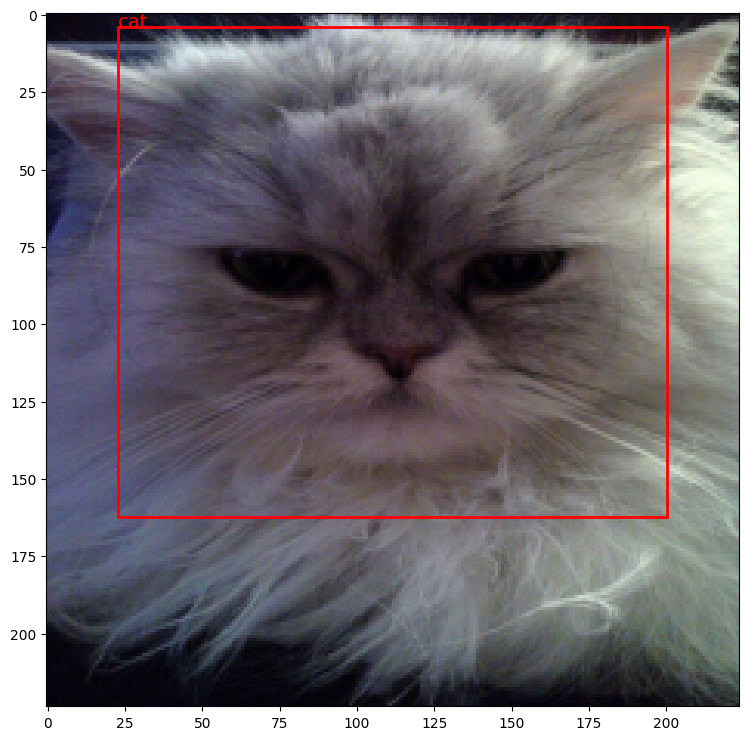

In [23]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

**Explanation** <br><br>
After thorough experimentation, I refined the network configuration to optimally address our problem, as detailed below:<br>
In the **classification** segment, I integrated two additional fully connected layers, employing the ReLU activation function and implementing dropout on the initial layer of this pair. This design choice enhances the model's ability to generalize by reducing overfitting.<br><br>
For the **localization** component, I adopted a similar architectural framework but increased the neuron count in the first fully connected layer. Recognizing that the pre-trained network excelled in classification yet lacked localization training, expanding its capacity was deemed essential for facilitating more robust learning in this area.<br><br>
To accelerate the training process and focus computational resources on the newly added components, I froze the backbone of the network. This approach restricts updates to the pre-trained layers during backpropagation, substantially reducing the number of trainable parameters. As a result, training becomes more efficient, requiring less computational power and time while still leveraging the pre-trained model's learned features.<br><br>
The outcomes, as illustrated in the ensuing charts, are compelling. The network achieved a classification accuracy nearing 99% on the validation set, alongside an IoU of approximately 77% as we can see from the visualizations below.<br><br>
In addressing the loss contributions from both tasks, I prioritized the localization aspect by amplifying the loss of the localization part by a relatively large number (8), thats because the net was good at the classification task so I wanted to give a higher weight on the localization task.

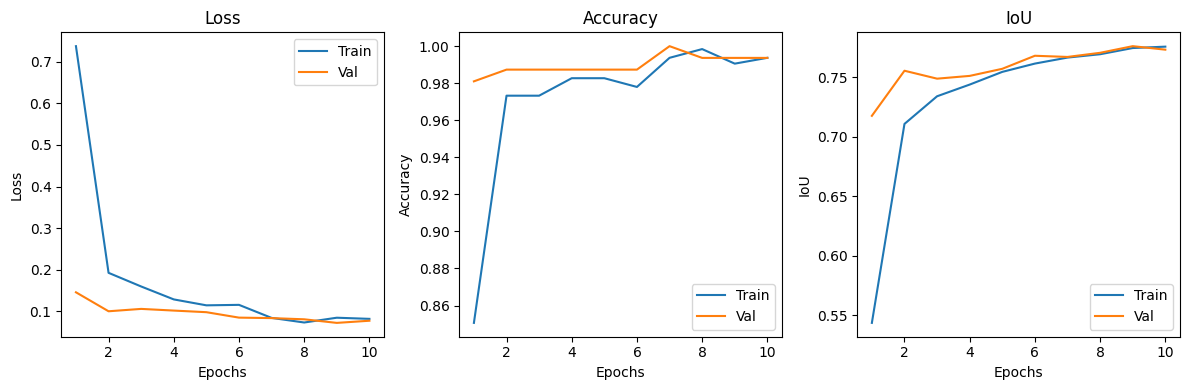

In [24]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train']['loss']) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, metrics['train']['loss'], label='Train')
    plt.plot(epochs, metrics['val']['loss'], label='Val')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, metrics['train']['acc'], label='Train')
    plt.plot(epochs, metrics['val']['acc'], label='Val')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, metrics['train']['iou'], label='Train')
    plt.plot(epochs, metrics['val']['iou'], label='Val')
    plt.title('IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(metrices)